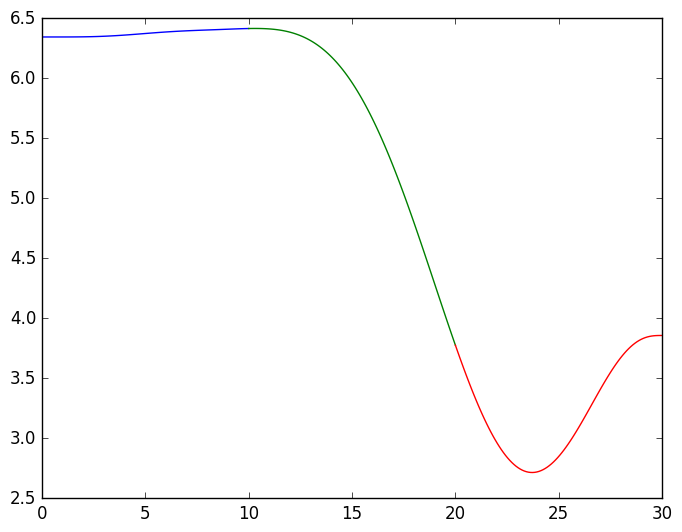

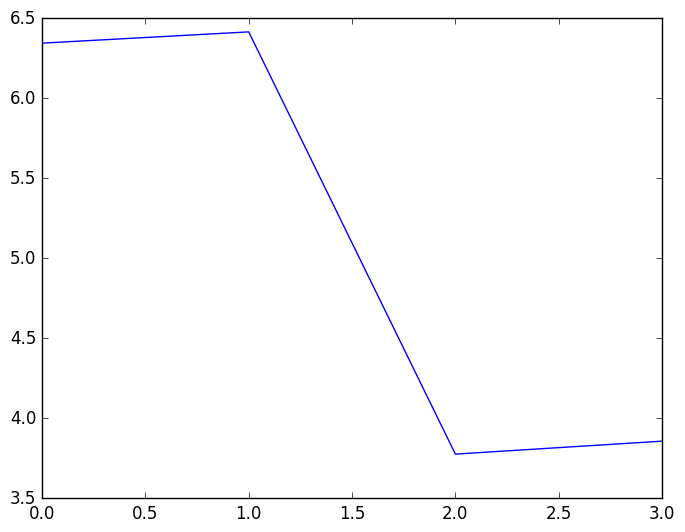

10
10


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000025542160>

In [1]:
# This code is an attempt work on multi-segment. This is the least tested/thought out of the bunch.

using PyPlot
# We need to be less lazy about computing A now. This is a function which returns a row vector corresponding to a constraint of given order at the given time.
function constr_order( order, time, degree)
    if(order==0) 
        row_vec = ones(1,degree); 
        for n=2:degree
            row_vec[1,n] = time^(n-1);
        end
        return row_vec;
    end
    row_vec = zeros(1,degree);
    for n = order:degree-1
        coeff = 1; 
        for k=1:order
            coeff = coeff*(n+1-k)
        end

        row_vec[1,n+1] = coeff * (time^(n-order))
    end
    return row_vec;
end
############################################################################################################
function form_Q(Q_coeffs, t)
    degree = size(Q_coeffs,1)
    Q_mat = zeros(degree,degree)

    for k = 0:degree-1
        if(Q_coeffs[k+1] == 0)
            continue;
        end
        c_k = Q_coeffs[k+1];
        for i=1:degree
        # Form Q
            for l = 1:degree
                if(i >= k && l >= k)                                                   
                    c_tmp = 2*c_k
                    for m = 0:k-1 
                        c_tmp = c_tmp * (i-m)*(l-m);
                    end                                                                
                    Q_mat[i,l] += c_tmp*(t^(i+l-2*k+1))/(i+l-2*k+1)                    
                end
            # Else 0
            end
        end
    end 
    return Q_mat                                                                       
end
######################################Variables to change##################################################
num_points = 4
xvals = rand(num_points)*10;
yvals = rand(num_points)*10
points = [xvals yvals zeros(num_points,2)];
#figure(42); clf(); scatter(xvals, yvals);

initial_cont = 2;
final_cont = 2;
cont_order = 5; # order of continuity to enforce
vinit = [1,0,0,0]; vfinal =[1,0,0,0];
ainit = [0,0,0,0]; afinal =[0,0,0,0];
times = linspace(0,4,num_points);
period = 10;
num_segs = num_points-1;
#########################################################################################################

#Calculate/Set the degree of each polynomial
degree=10;


####################Create the A matrices for each set of polynomials#########################
#create the order vectors, can be optimized later
#Organized as Fixed and Free constraints
#For the first and last polynomials there is a different # of free and fixed to take into account
#v = velocity, a = acceleration, j = jerk, s = snap i= initial, e = end
#       fixed      point  i-v a j s    free e- v a j s                                     
order1 = [zeros(Int64,2);   [1;2;3;4];            [1;2;3;4]]; #first poly
order2 = [zeros(Int64,2);   [1;2;3;4];           [1;2;3;4]]; #middle poly
#      fixed    point     i-v,a,j,s e-v,a  free e- j s
order3 = [zeros(Int64,2);   1;2;3;4;   1;2;         3;4]; #end poly
#create time indexes too from the time vector Done by hand here
time1 = [0,1,0,0,0,0,1,1,1,1]*period;
time2 = [1,2,1,1,1,1,2,2,2,2]*period;
time3 = [2,3,2,2,2,2,3,3,3,3]*period;

#Create the actual A matrices now after initializing
A_1=zeros(degree,degree);
A_2=zeros(degree,degree);
A_3=zeros(degree,degree);
for n=1:degree
    #All constrainst done at once - Can be changed later
    A_1[n,:] = constr_order(order1[n],time1[n],degree);
    A_2[n,:] = constr_order(order2[n],time2[n],degree);
    A_3[n,:] = constr_order(order3[n],time3[n],degree);
end
#Create block diagonal A
println(size(zeros(degree,degree),1))
println(size(zeros(degree,degree),2))
A_big = [[A_1 zeros(degree,degree) zeros(degree,degree)];
        [zeros(degree,degree) A_2 zeros(degree,degree)];
        [zeros(degree,degree) zeros(degree,degree) A_3]];

###############################################################################################


####################Create the Q matrix #######################################3
# To optimize for snap, we weight the 5th component:
q_coeffs = zeros(degree);
q_coeffs[3] = 1.0;
#Create small Q
Q_small = form_Q(q_coeffs, period) 
#Make big q
Q_mat = [[Q_small zeros(degree,degree) zeros(degree,degree)];
        [zeros(degree,degree) Q_small zeros(degree,degree)];
        [zeros(degree,degree) zeros(degree,degree) Q_small]];
###################################################################

##################Create C matrix (done by hand for now#############################
#should change create larger constraint vector from a smaller vector of uniqure constraints
#it will be a size of degree x unigue constriant matrix, it is large
#Unique constraints as follows, there are 
#   1_01 1_02 1_1
C= [eye(6) zeros(6,20-6);
    #1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
    [zeros(1,10) 1 zeros(1,9)];#7
    [zeros(1,11) 1 zeros(1,8)]; #8
    [zeros(1,12) 1 zeros(1,7)]; #9
    [zeros(1,13) 1 zeros(1,6)];#10
    [zeros(1,1) 1 zeros(1,18)]; #11
    [zeros(1,6) 1 zeros(1,13)];#12
    [zeros(1,10) 1 zeros(1,9)];#13
    [zeros(1,11) 1 zeros(1,8)]; #14
    [zeros(1,12) 1 zeros(1,7)]; #15
    [zeros(1,13) 1 zeros(1,6)]; #16
    [zeros(1,14) 1 zeros(1,5)];#17
    [zeros(1,15) 1 zeros(1,4)]; #18
    [zeros(1,16) 1 zeros(1,3)]; #19
    [zeros(1,17) 1 zeros(1,2)]; #20
    [zeros(1,6) 1 zeros(1,13)]; #21
    [zeros(1,7) 1 zeros(1,12)]; #22
    [zeros(1,14) 1 zeros(1,5)]; #23
    [zeros(1,15) 1 zeros(1,4)]; #24
    [zeros(1,16) 1 zeros(1,3)]; #25
    [zeros(1,17) 1 zeros(1,2)]; #26
    [zeros(1,8) 1 zeros(1,11)]; #27
    [zeros(1,9) 1 zeros(1,10)];#28
    [zeros(1,18) 1 zeros(1,1)]; #29
    [zeros(1,19) 1]];#30]#

########################################################################################33

############################ Compute R = A^-T Q A^-1 ###################################                                                            
# This is bad practice, but easy:                                                      
Ainv = inv(A_big);
R = C'*(Ainv')*(Q_mat*Ainv*C)
#Calculate the number of fixed constraints and free somehow
num_fixed = 10;
num_unique = 20;
num_free = num_unique - num_fixed;

#          -     R_fp                                                     *   R_pp^-1
opt_mat = - inv(R[(num_fixed+1):num_unique,(num_fixed+1):num_unique])*R[1:num_fixed,(num_fixed+1):num_unique]'; 
##########################################################################################

###############################Compute optimal unconstrained condidtions#################
#       [xpts[1],xpts[2],vint[1],aint[1],jint[1],sint[1],xpts[3],xpts[4],vend, aend]
d_fixed = [xvals[1],xvals[2],0,0,0,0,xvals[3],xvals[4],0,0];
d_free_opt = opt_mat*d_fixed;
#create big constraint vector again to back out coefficients
d_consolidated=[d_fixed; d_free_opt];
coeffs = Ainv*C*d_consolidated;
########################################################################################3

# Plot the one dimesion vs time.
figure(2);
t = linspace(0,1*period,100);
#Create the vector for poly 1
x =0;
for p=1:degree
    x += coeffs[p]*t.^(p-1);
end
plot(t,x)
t = linspace(1*period,2*period,100);
#Create the vector for poly 2
x =0;
for p=(1:degree)+10
    x += coeffs[p]*t.^(p-11);
end
plot(t,x)
t = linspace(2*period,3*period,100);
#Create the vector poly 3
x =0;
for p=(1:degree)+20
    x += coeffs[p]*t.^(p-21);
end
plot(t,x)
figure(3)
plot([0,1,2,3],xvals)

In [118]:
for g=1:30#length(A_big)
    println(A_big[g,:]);
end
println();
coeffg=Ainv*((C*d_consolidated))
println((coeffg)[11:20])


[1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,2.0,6.0,12.0,20.0,30.0,42.0,56.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,6.0,

In [90]:
println(C*d_consolidated)
println((C*d_consolidated)[11:20])


[1.0,2.0,0.0,0.0,0.0,0.0,1.82856,0.206718,-4.74324,-25.2638,2.0,3.0,1.82856,0.206718,-4.74324,-25.2638,0.105296,1.06621,16.2965,-3.13397,3.0,4.0,0.105296,1.06621,16.2965,-3.13397,0.0,0.0,106.163,1047.66]
[2.0,3.0,1.82856,0.206718,-4.74324,-25.2638,0.105296,1.06621,16.2965,-3.13397]


In [47]:
C= [eye(6) zeros(6,20-6);
    #1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
    [zeros(1,10) 1 zeros(1,9)];#7
    [zeros(1,11) 1 zeros(1,8)]; #8
    [zeros(1,12) 1 zeros(1,7)]; #9
    [zeros(1,13) 1 zeros(1,6)];#10
    [zeros(1,1) 1 zeros(1,18)]; #11
    [zeros(1,6) 1 zeros(1,13)];#12
    [zeros(1,10) 1 zeros(1,9)];#13
    [zeros(1,11) 1 zeros(1,8)]; #14
    [zeros(1,12) 1 zeros(1,7)]; #15
    [zeros(1,13) 1 zeros(1,6)]; #16
    [zeros(1,14) 1 zeros(1,5)];#17
    [zeros(1,15) 1 zeros(1,4)]; #18
    [zeros(1,16) 1 zeros(1,3)]; #19
    [zeros(1,17) 1 zeros(1,2)]; #20
    [zeros(1,6) 1 zeros(1,13)]; #21
    [zeros(1,7) 1 zeros(1,12)]; #22
    [zeros(1,14) 1 zeros(1,5)]; #23
    [zeros(1,15) 1 zeros(1,4)]; #24
    [zeros(1,16) 1 zeros(1,3)]; #25
    [zeros(1,17) 1 zeros(1,2)]; #26
    [zeros(1,8) 1 zeros(1,11)]; #27
    [zeros(1,9) 1 zeros(1,10)];#28
    [zeros(1,18) 1 zeros(1,1)]; #29
    [zeros(1,19) 1]];#30]#
    
d=1:20;
cod = C*d;
println(length(cod));
for b = 1:length(cod)
    println(cod[b])
end

30
1.0
2.0
3.0
4.0
5.0
6.0
11.0
12.0
13.0
14.0
2.0
7.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
7.0
8.0
15.0
16.0
17.0
18.0
9.0
10.0
19.0
20.0


In [138]:
t = linspace(0,1,100);
#Create the vector
x =0;
for p=1:degree+10
    print(p-11)
    x += coeffg[p]*1.^(p-11);
end
#plot(t,x)
println(x);

-10

LoadError: LoadError: DomainError:
Cannot raise an integer x to a negative power -n. 
Make x a float by adding a zero decimal (e.g. 2.0^-n instead of 2^-n), or write 1/x^n, float(x)^-n, or (x//1)^-n.
while loading In[138], in expression starting on line 4

In [106]:
order1 = [zeros(Int64,2,1);   [1;2;3;4];            [1;2;3;4]];
print(order1)

[0; 0; 1; 2; 3; 4; 1; 2; 3; 4]

In [ ]:
t = linspace(1,2,100);
#Create the vector
x =0;
for p=1:degree
    x += coeffs[p]*t.^(p-1);
end
plot(t,x)
t = linspace(2,3,100);
#Create the vector
x =0;
for p=1:degree
    x += coeffs[p]*t.^(p-1);
end
plot(t,x)